# Classification d’images 

Un ami enseignant vous explique qu'il souhaiterait utiliser une application de labellisation automatique d'images pour l'assister dans ses ateliers avec des enfants de maternelle. Au fil des années, il a accumulé de très nombreuses images d'animaux permettant d'évoquer différents thèmes tels que la jungle, la forêt, la ferme etc. Malheureusement ces images ne sont pas triés et représentent 500 Go de données sur un disque dur ! En tant que scientifique et remplis d'empathie, vous vous dites que vous ne pouvez pas laisser votre ami chercher pendant plusieurs heures les photos qui lui permettront d'appréhender sereinement le thème de la ferme le lendemain. L’idée soudaine vous vient de créer un algorithme de classification d’images qui lui permettrait par la suite de labelliser automatiquement ses magnifiques images. Enthousiaste par votre brillante idée, vous commencez par vous congratuler, puis lui promettez de revenir vers lui dans quelques jours avec le logiciel qui va révolutionner son emploi du temps en lui évitant de nombreuses heures de recherches dans ses données !

Nous allons construire un modèle de base pour classer les images en fonction de leurs caractéristiques HOG. Ce projet va vous permettre de mettre en place des mécanismes d’automatisation de pipeline de données et de recherche de paramètres optimaux pour des modèles de classification. Cette méthodologie est générique et peut être appliquée à toutes sortes de problèmes d'apprentissage automatique.


## Références

https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/exp5.html <br>
https://zestedesavoir.com/tutoriels/1760/un-peu-de-machine-learning-avec-les-svm/ <br>
https://towardsdatascience.com/cat-or-dog-introduction-to-naive-bayes-c507f1a6d1a8 <br>
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

## 0. Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import joblib
from collections import Counter

## skimage
from skimage.io import imread
from skimage.transform import resize
from skimage import filters

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2


## 1. Décompressez les données dans un dossier, qui sera le chemin source. 
Dataset : https://vcla.stat.ucla.edu/people/zhangzhang-si/HiT/AnimalFace.zip

## 2. Définissez une fonction pour lire, redimensionner et stocker les données dans un dictionnaire, contenant les images, les étiquettes (animal), les noms de fichiers originaux et une description. 

Les images elles-mêmes seront stockées sous forme de tableaux numpy contenant leurs valeurs RVB. Le dictionnaire sera enregistré dans un fichier pickle à l'aide de la librairie joblib. La structure des données sera basée sur celle utilisée pour les ensembles de données de test dans scikit-learn.

### Fonction resize all

In [2]:
def resize_all(src, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   

    #pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
            
            nb = 0
            for file in os.listdir(current_path):
                if (file[-3:] in {'jpg', 'png'}) and nb <=100:
                    im = imread(os.path.join(current_path, file))
                    if len(im.shape)!=3:
                        print(file)
                        print(im.shape)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
                    nb+=1
    return data
        #joblib.dump(data, pklname)

In [3]:
data_path = fr'{os.getenv("HOME")}/Documents/Briefs/2_Block_janv_fev/20210204_Reco_images_SGD_SVM_NB/Datas'
os.listdir(data_path)[:5]

['PandaHead', 'WolfHead', 'RabbitHead', 'TigerHead', 'CatHead']

## 3. Créer le jeu de données en vous servant de votre fonction précédemment créée. Il y a pas mal d'animaux inclus dans le jeu de données, sélectionnez 8 classes d’animaux de votre choix. Nous définissons la largeur (et la hauteur) à 80 pixels.

In [4]:
#### base_name = 'animal_faces'
width = 120

include_animals = {'BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 
          'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'PandaHead', 'PigeonHead',
           'PigHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead'}

#include_animals = {'ChickenHead', 'BearHead', 'ElephantHead', 'RabbitHead', 'HumanHead',
#          'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead', 'DogHead'}

data = resize_all(src=data_path, width=width, include=include_animals)

PandaHead
WolfHead
RabbitHead
TigerHead
CatHead
DuckHead
MouseHead
PigHead
HumanHead
ElephantHead
EagleHead
DeerHead
LionHead
DogHead
PigeonHead
MonkeyHead
ChickenHead
SheepHead
CowHead
BearHead


## 4. Analysez le nouveau jeu de données fraîchement créé (nombre d’échantillons, les éléments “clés” des données, taille des images, labels des images).


In [5]:
#data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  2001
keys:  ['description', 'label', 'filename', 'data']
description:  resized (120x120)animal images in rgb
image shape:  (120, 120, 3)
labels: ['Bear' 'Cat' 'Chicken' 'Cow' 'Deer' 'Dog' 'Duck' 'Eagle' 'Elephant'
 'Human' 'Lion' 'Monkey' 'Mouse' 'Panda' 'Pig' 'Pigeon' 'Rabbit' 'Sheep'
 'Tiger' 'Wolf']


Counter({'Panda': 101,
         'Wolf': 100,
         'Rabbit': 100,
         'Tiger': 101,
         'Cat': 101,
         'Duck': 101,
         'Mouse': 100,
         'Pig': 101,
         'Human': 100,
         'Elephant': 100,
         'Eagle': 97,
         'Deer': 101,
         'Lion': 97,
         'Dog': 101,
         'Pigeon': 98,
         'Monkey': 100,
         'Chicken': 100,
         'Sheep': 100,
         'Cow': 101,
         'Bear': 101})

## 5. Affichez un exemple de chaque animal inclus dans le jeu de données :

* Utilisez “np.unique” pour obtenir toutes les valeurs uniques dans la liste des étiquettes.
* Configurer la figure et les axes matplotlib, en fonction du nombre d'étiquettes.
* Faire un tracé pour chaque type d'étiquette. La méthode index renvoie l'index du premier élément correspondant à sa chaîne de recherche, label dans notre cas


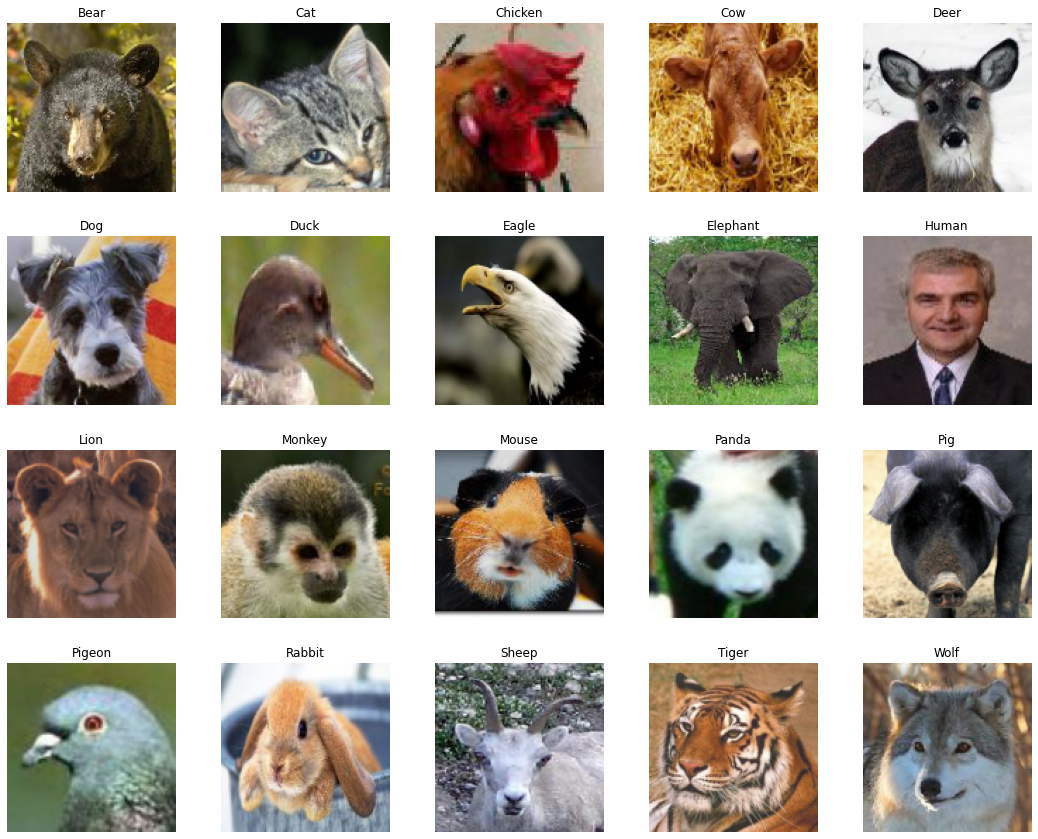

In [6]:
labels = np.unique(data['label'])

length = 5
xsub = length
ysub = len(labels)//length
if len(labels)%length!=0: ysub+=1

#fig, axes = plt.subplots(1, len(labels))
fig, axes = plt.subplots(ysub, xsub)
fig.set_size_inches(15,3*ysub)
fig.tight_layout()

axes = axes.ravel()
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

## 6. Diviser vos données en un ensemble de test et un ensemble de train 
avec la fonction train_test_split de scikit-learn (80% de l'ensemble total pour l'entraînement et le reste pour l'ensemble de test). 

Dans l'ensemble de données, les photos sont classées par animal, nous ne pouvons donc pas simplement diviser à 80%, (si les données sont ordonnées et que nous nous divisons à une certaine position, nous nous retrouverons avec certains animaux (types) apparaissant dans un seul des deux ensembles).

Nous pouvons résoudre ce problème en mélangeant les données avant de les fractionner. De cette façon, nous égalisons les distributions dans l'ensemble de train et de test et les rendons comparables. La fonction “train_test_split” de sklearn fournit un paramètre shuffle pour prendre en charge cela tout en effectuant le fractionnement. “Random_state” amorce le mélange pour qu'il soit aléatoire, mais de manière reproductible.

In [7]:
X = np.array(data['data'])
y = np.array(data['label'])
del data

In [39]:
X

array([[[[0.50612745, 0.57028186, 0.41458333],
         [0.47487745, 0.55723039, 0.3877451 ],
         [0.47640931, 0.59338235, 0.40612745],
         ...,
         [0.42751225, 0.34534314, 0.34123775],
         [0.50349265, 0.42132353, 0.41721814],
         [0.57573529, 0.49338235, 0.48946078]],

        [[0.51734069, 0.58210784, 0.41556373],
         [0.46875   , 0.55147059, 0.37610294],
         [0.44761029, 0.56617647, 0.36966912],
         ...,
         [0.38995098, 0.31237745, 0.30661765],
         [0.49136029, 0.41378676, 0.40802696],
         [0.58995098, 0.5120098 , 0.50661765]],

        [[0.44656863, 0.5088848 , 0.33498775],
         [0.42371324, 0.50306373, 0.32034314],
         [0.41176471, 0.52696078, 0.32310049],
         ...,
         [0.34460784, 0.27990196, 0.27598039],
         [0.46286765, 0.3966299 , 0.3942402 ],
         [0.5807598 , 0.51507353, 0.51213235]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, stratify=y, random_state=42)

Pour s'assurer que les données sont mélangées avant le partage on utilise le paramètre suffle True

## 7. Vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire, (examiner le nombre relatif de photos par catégorie).

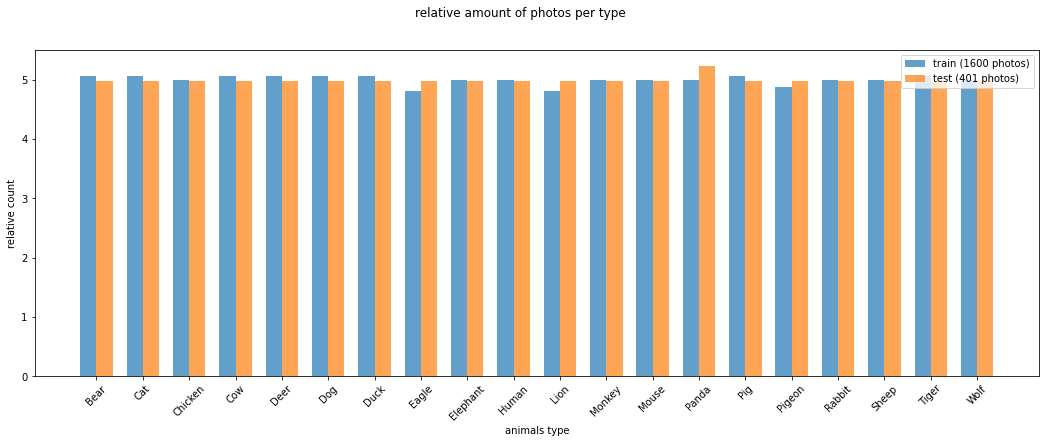

In [9]:
def plot_hist(y, loc='left'):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
    counts = 100*counts[sorted_index]/y.shape[0]
    
    plt.bar(np.arange(len(unique)) +n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(np.arange(len(unique)), unique, rotation=45)
    plt.xlabel('animals type')
    plt.ylabel('relative count')

plt.figure(figsize=(18,6))
plt.suptitle('relative amount of photos per type')
plot_hist(y_train, loc='left')
plot_hist(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

Les didistrubition du nombre relatif des photos par catégorie dans le train et le test set sont identique. Pour ce faire nous avons utilisé le paramètre stratify (sur les label y).

Pour s'en assurer ( en plus de la représentation graphique ci-dessus), je réalise un test de chi2 entre les deux set.

In [10]:
col1 = 'set'
col2 = 'annimals'
vect1 = ['train']*len(y_train)
vect1.extend(['test']*len(y_test))
vect2 = list(y_train)
vect2.extend(list(y_test))
data2 = {
    col1 : vect1,
    col2 : vect2
}
df = pd.DataFrame(data2)
pivot = df.pivot_table(index=col1, columns=col2, aggfunc=len)

In [11]:
#pivot['Human'].train=0

In [12]:
pivot

annimals,Bear,Cat,Chicken,Cow,Deer,Dog,Duck,Eagle,Elephant,Human,Lion,Monkey,Mouse,Panda,Pig,Pigeon,Rabbit,Sheep,Tiger,Wolf
set,,,,,,,,,,,,,,,,,,,,
test,20,20,20,20,20,20,20,20,20,20,20,20,20,21,20,20,20,20,20,20
train,81,81,80,81,81,81,81,77,80,80,77,80,80,80,81,78,80,80,81,80


In [13]:
import scipy.stats as st
st_chi2, st_p, st_dof, st_exp = st.chi2_contingency(pivot)
print('chi2 :', st_chi2)
print('p-value', st_p)

chi2 : 0.11383222501673806
p-value 1.0


En tant normal on utilise la p-value pour déterminer si deux variables sont indépendantes (lorsque p-value est inférieur à un seuil), ici au contraire les répartitions des différentes classe sont quasiment identiques.

## 8. Traitement des données
Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogramme des dégradés orientés (Histogram of Oriented Gradients) et Support Vector Machines. Les HOG sont utilisés pour la réduction des caractéristiques, en d'autres termes : pour réduire la complexité du problème, tout en conservant autant de variations que possible.

Pour calculer un HOG, une image est divisée en blocs, par exemple 8 par 8 pixels. Pour chacun de ces blocs, la magnitude du gradient dans un nombre donné de directions est calculée. Pour une explication détaillée, vous pouvez vous référer à ce tutoriel : http://www.learnopencv.com/histogram-of-oriented-gradients/.

Les librairies utilisées pour obtenir le résultat ci-dessus sont les suivantes :
* from skimage.feature import hog
* from skimage.io import imread
* from skimage.transform import rescale

Lors du calcul du HOG, nous effectuons une transformation. Nous pouvons transformer l'ensemble de notre ensemble de données à l'aide de transformateurs. Les transformateurs sont des objets qui se servent dans le tableau de données, transforment chaque élément et renvoient les données résultantes.

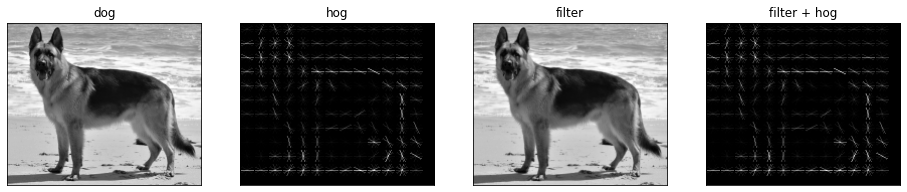

In [14]:
from skimage.feature import hog, canny
from skimage.io import imread
from skimage.transform import rescale
 
dog = imread('./Datas/German_Shepherd.jpg', as_gray=True)
# https://en.wikipedia.org/wiki/German_Shepherd#/media/File:Kim_at_14_weeks.jpg
 
# scale down the image to one third

dog = rescale(dog, 1/3, mode='reflect')

## apply filters before hog
dog_roberts = filters.roberts(dog)
dog_sobel = filters.sobel(dog)
dog_scharr = filters.scharr(dog)
dog_prewitt = filters.prewitt(dog)
dog_gaussian = filters.gaussian(dog, sigma=0.4)
#dog_canny = canny(dog, sigma=4)

# calculate the hog and return a visual representation.
dog_hog, dog_hog_img = hog(dog, pixels_per_cell=(14,14), cells_per_block=(2, 2), 
                           orientations=9, visualize=True, block_norm='L2-Hys')

# calculate the hog and return a visual representation after filter.
dog_filter_hog, dog_filter_hog_img = hog(dog_gaussian, pixels_per_cell=(14,14), cells_per_block=(2, 2), 
                           orientations=9, visualize=True, block_norm='L2-Hys')


fig, ax = plt.subplots(1,4)
fig.set_size_inches(16,6)

# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
 
ax[0].imshow(dog, cmap='gray')
ax[0].set_title('dog')
ax[1].imshow(dog_hog_img, cmap='gray')
ax[1].set_title('hog')
ax[2].imshow(dog_gaussian, cmap='gray')
ax[2].set_title('filter')
ax[3].imshow(dog_filter_hog_img, cmap='gray')
ax[3].set_title('filter + hog')
plt.show()

In [15]:
print('nombre de pixel: ', dog.shape[0]*dog.shape[1])
print("nombre d'élements du hog: ", dog_hog.shape[0])
print(f"pourcentage de réduction : \
{100*(1-(dog.shape[0]*dog.shape[1]-dog_hog.shape[0])/(dog.shape[0]*dog.shape[1])):.2f} %")

nombre de pixel:  31428
nombre d'élements du hog:  4320
pourcentage de réduction : 13.75 %


**Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre à l'échelle les données. Pour cela, nous utilisons trois transformateurs à la suite: RGB2GrayTransformer, HOGTransformer et StandardScaler. Le résultat final est un tableau avec un HOG pour chaque image de l'entrée.**

Scikit-learn est livré avec de nombreux transformateurs intégrés, tels qu'un StandardScaler pour mettre à l'échelle des entités et un Binarizer pour mapper des entités de chaîne à des entités numériques. De plus, il fournit les classes BaseEstimator et TransformerMixin pour faciliter la création de vos propres Transformers.
Un transformateur personnalisé peut être créé en héritant de ces deux classes (BaseEstimator, TransformerMixin) et en implémentant une méthode __init__, fit() et transform(). La classe TransformerMixin fournit la méthode fit_transform(), qui combine l'ajustement et la transformation que nous avons implémentés.

**Créer vos classes RGB2GrayTransformer and HOGTransformer**
Après avoir instancié chaque transformateur (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), mettez à l’échelle votre échantillon de données en appelant fit_transform() à chaque transformation en convertissant X_train étape par étape (RGB2GrayTransformer, puis HogTransformer, puis StandardScaler)


In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])

In [17]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X, orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [18]:
class SobelFilter(BaseEstimator, TransformerMixin):
    """
    Apply sobel filter to the img
    """
    
    def __init__(self, y = None):
        self.y = y
    
    def fit(self, X, y=None):
        """returns itself"""
        return self
       
    def transform(self, X, y=None):
        """perform the Sobel transformation and return an array"""
        return np.array([filters.sobel(img) for img in X])

In [19]:
class GaussianFilter(BaseEstimator, TransformerMixin):
    """
    Apply sobel filter to the img
    """
    
    def __init__(self, y = None, sigma=1):
        self.y = y
        self.sigma = sigma
    
    def fit(self, X, y=None):
        """returns itself"""
        return self
       
    def transform(self, X, y=None):
        """perform the Sobel transformation and return an array"""
        return np.array([filters.gaussian(img, sigma=self.sigma) for img in X])

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
import skimage
from sklearn.pipeline import Pipeline

transformer = Pipeline([
    ('rbg2grey', RGB2GrayTransformer()),
    #('sobel', SobelFilter()),
    ('gauss', GaussianFilter(sigma=1)),
    ('hog', HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2,2), 
                           orientations=9, block_norm='L2-Hys')),
    ('StandScal', StandardScaler())
])

X_train_prepared = transformer.fit_transform(X_train)

## 9. Entraîner un classifieur. Nous commencerons par Stochastic Gradient Descent (SGD), car il est rapide et fonctionne relativement bien.

In [21]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

In [22]:
X_test_prepared = transformer.fit_transform(X_test)
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print(f'Percentage of correct predictions: {100*np.sum(y_pred == y_test)/len(y_test):.2f} %')

[ True  True  True False  True False  True  True False False  True  True
  True False False False  True  True  True  True  True False False  True
  True]

Percentage of correct predictions: 75.56 %


## 10. Évaluer les faux positifs grâce à une matrice de confusion.

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from sklearn.metrics import f1_score
 
def plot_confusion_matrix(cm, f1=0, n_fig=3):
    cm_norm = 100*cm / cm.sum(axis=1, keepdims=True)
    cm_zero_diag = cm_norm.copy()
 
    np.fill_diagonal(cm_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=n_fig)
    fig.set_size_inches(18, 6)
    [a.set_xticks(range(len(cm)+1)) for a in ax]
    [a.set_yticks(range(len(cm)+1)) for a in ax]
    
    if n_fig==3:
        sns.heatmap(cm, ax=ax[n_fig-3], annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
        ax[n_fig-3].set_title('confusion matrix (count)',size = 20)
        ax[n_fig-3].set_ylabel('Actual label');
        ax[n_fig-3].set_xlabel('Predicted label');
        
    sns.heatmap(cm_norm, ax=ax[n_fig-2], annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
    ax[n_fig-2].set_title(f'confusion matrix (%) \n f1 score ={100*f1:.2f} %')
    ax[n_fig-2].set_ylabel('Actual label');
    ax[n_fig-2].set_xlabel('Predicted label');
    
    sns.heatmap(cm_zero_diag, ax=ax[n_fig-1], annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
    ax[n_fig-1].set_title(f'confusion matrix (%) \n only false predictions \n f1 score ={100*f1:.2f} %')
 
    fig.tight_layout()
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
 


 ['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


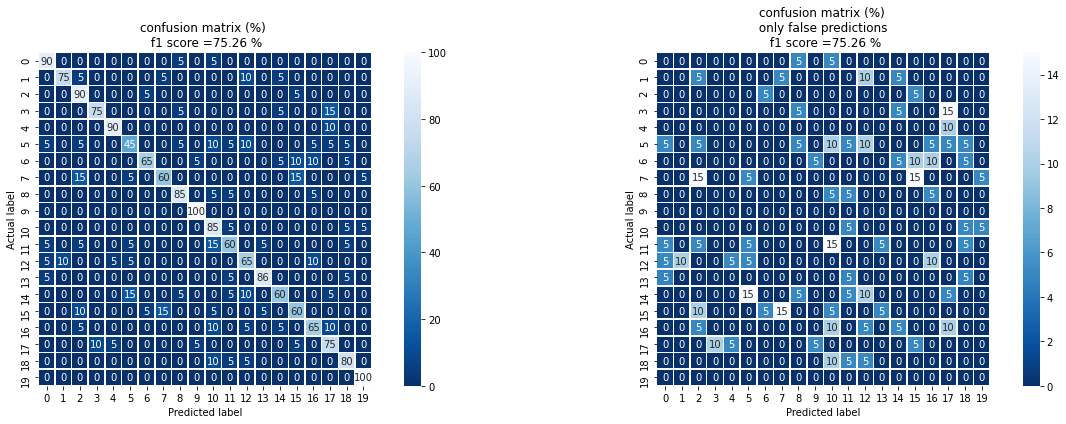

In [25]:
le = LabelEncoder()
le.fit(y)

f1 = f1_score(le.transform(y_test), le.transform(y_pred), average='macro')
plot_confusion_matrix(cm, f1, n_fig=2)

# the types appear in this order
print('\n', sorted(np.unique(y_test)))

La plupart des erreur sont des prédictions d'ours alors qu'il s'agit d'éléphants ou de singes. Un autre type d'erreur est la prédiction d'aigle alors qu'il s'agit de pandas.

### Display Misclassified images with Predicted Labels

In [26]:
def missclass(y_pred, y_test):
    index = 0
    misclassifiedIndex = []
    for predict, actual in zip(y_pred, y_test):
        if predict != actual: 
            misclassifiedIndex.append(index)
        index +=1
    return misclassifiedIndex
misclassifiedIndex = missclass(y_pred, y_test)

<ipython-input-27-0b18403ef2f8>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


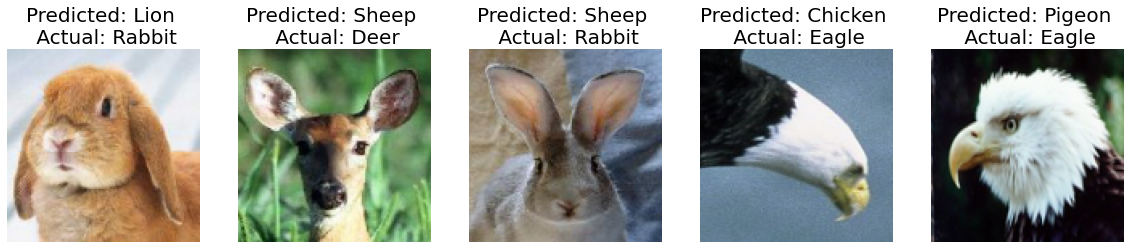

In [27]:
def plot_missclass(X_test, y_test, y_pred, misclassifiedIndex):
    plt.figure(figsize=(20,4))
    for plotIndex, wrong in enumerate(misclassifiedIndex[0:5]):
        plt.subplot(1, 5, plotIndex + 1)
        plt.imshow(X_test[wrong], cmap=plt.cm.gray)
        plt.title('Predicted: {} \n Actual: {}'.format(y_pred[wrong], y_test[wrong]), fontsize = 20)
        fig.tight_layout()
        plt.axis('off')
        fig.show()

plot_missclass(X_test, y_test, y_pred, misclassifiedIndex)

## 11. Mettre en place un pipeline qui pré-traite les données (RGB2GrayTransformer(), HogTransformer(), StandardScaler()), entraîne le modèle et nous permet de modifier les paramètres plus facilement.
En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et le classificateur en une seule procédure. De plus, au lieu de modifier manuellement les paramètres, nous pouvons utiliser un GridSearchCV. 

In [28]:
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, GaussianNB

from pipelinehelper import PipelineHelper

pipe = Pipeline([
    ('rbg2grey', RGB2GrayTransformer()),
    ('hog', HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2, 2), 
                           orientations=9, block_norm='L2-Hys')
    ),
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MaxAbsScaler()),
    ])),
    ('classifier', PipelineHelper([
        ('sgd', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)),
        ('svm', SVC()),
        ('gnb', GaussianNB()),
        ('cnb', ComplementNB()),
    ])),
])

## 12.Pour cela, définir une grille de paramètres (param_grid = [{...}]).

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
params = {
    'hog__orientations': [8, 9],
    'hog__cells_per_block': [(2, 2), (3, 3), (4, 4)],
    'hog__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'sgd__loss': ['hinge', 'log', 'modified_huber', 'perceptron', 'squared_loss', 'huber'],
        'svm__C': [0.1, 1.0],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    })
}

list_combin_params = list(ParameterGrid(params))
#list_combin_params

## 13. Evaluer dans le même objet Grid Search, le classifieur SGD, le classifieur SVM, ainsi qu’un classifieur Naïve Bayes.

Une fois le Grid Search terminé, le modèle sera entraîné une dernière fois, en utilisant l'ensemble complet d'apprentissage et les paramètres optimaux. 

Que pouvez-vous conclure de ces modèles, en étudiant le fonctionnement intrinsèque du SVM et du Naive Bayes, est-on capable d’anticiper quel algorithme sera le plus efficace pour cette tâche de classification d’images ? 

## 14. Évaluer les résultats des modèles (avec paramètres optimaux calculés par le Grid Search), quel classifieur offre de meilleurs scores pour cette tâche ?

## 15. Enregistrer vos résultats dans un fichier pickle (joblib) afin de pouvoir recharger les résultats lorsque vous en aurez besoin (par ex avec Heroku). 


In [28]:
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)
gs = GridSearchCV(pipe, 
                  params, 
                  cv=3,
                  n_jobs=-1,
                  scoring='accuracy',
                  verbose=1,
                  return_train_score=True)
 
gs_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 93.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 150.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 324.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 678.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 906.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 1075.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 1362.6min
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed: 1441.3min finished


In [29]:
print('meilleur score obtenu :', gs_res.best_score_)
print('meilleur estimateur :', gs_res.best_estimator_)
print('meilleur paramètres :', gs_res.best_params_)

meilleur score obtenu : 0.8012580428310766
meilleur estimateur : Pipeline(steps=[('rbg2grey', RGB2GrayTransformer()),
                ('hog', HogTransformer(pixels_per_cell=(12, 12))),
                ('scaler',
                 PipelineHelper(available_models={'max': MaxAbsScaler(),
                                                  'std': StandardScaler(with_mean=False,
                                                                        with_std=False)},
                                selected_model=StandardScaler(with_mean=False,
                                                              with_std=False))),
                ('classifier',
                 PipelineHelper(available_models={'cnb': ComplementNB(),
                                                  'gnb': GaussianNB(),
                                                  'sgd': SGDClassifier(random_state=42),
                                                  'svm': SVC(kernel='poly')},
                                se

meilleur paramètres : {'classifier__selected_model': ('svm', {'C': 1.0, 'kernel': 'rbf'}), 'hog__cells_per_block': (3, 3), 'hog__orientations': 8, 'hog__pixels_per_cell': (8, 8), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': False})}

### Meilleur modèle

In [30]:
model_best = Pipeline([
    ('rbg2grey', RGB2GrayTransformer()),
    ('hog', HogTransformer(pixels_per_cell=(8, 8), cells_per_block=(3,3), 
                           orientations=8, block_norm='L2-Hys')),
    ('StandScal', StandardScaler(with_mean=True, with_std=False)),
    ('svm', SVC(C=1.0, kernel='rbf'))
]) ## pour le premier test peu d'images

model_best = Pipeline([
    ('rbg2grey', RGB2GrayTransformer()),
    ('hog', HogTransformer(pixels_per_cell=(12, 12), cells_per_block=(3,3), 
                           orientations=9, block_norm='L2-Hys')),
    ('StandScal', StandardScaler(with_mean=False, with_std=False)),
    ('svm', SVC(C=1.0, kernel='poly'))
]) ## pour le premier toutes les images


In [31]:
model_best.fit(X_train, y_train)
y_pred = model_best.predict(X_test)


 ['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


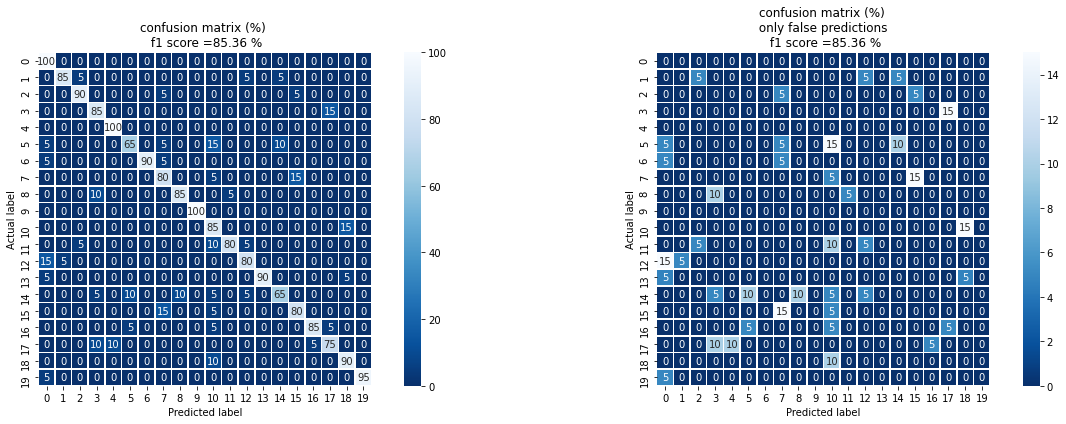

In [32]:
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(le.transform(y_test), le.transform(y_pred), average='macro')
plot_confusion_matrix(cm, f1, n_fig=2)

# the types appear in this order
print('\n', sorted(np.unique(y_test)))

<ipython-input-27-0b18403ef2f8>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


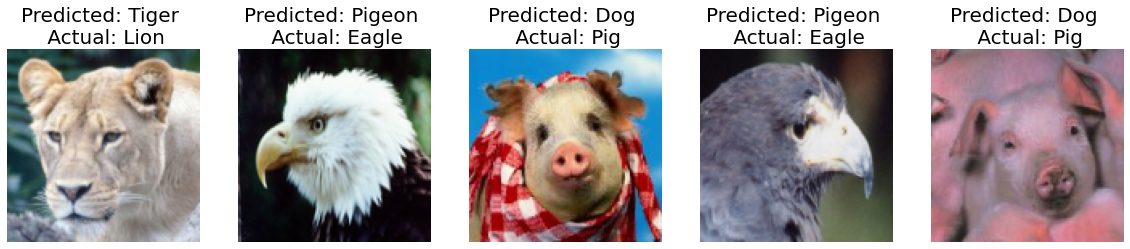

In [33]:
misclassifiedIndex = missclass(y_pred, y_test)
plot_missclass(X_test, y_test, y_pred, misclassifiedIndex)

In [34]:
## sauvegarde
import pickle
filename = "classif_img.pickle"
pickle.dump(model_best, open(filename, 'wb'))

## 16. Créer votre propre dataset avec des images provenant de Google Image. Appliquer votre pipeline sur ce nouveau jeu de données. Au besoin, relancer un Grid Search.

In [36]:
from selenium import webdriver
import time
import requests
import pandas as pd
import io

# Put the path for your ChromeDriver here
DRIVER_PATH = fr'{os.getenv("HOME")}/Bureau/Scraping/chromedriver_linux64/chromedriver'

wd = webdriver.Chrome(executable_path=DRIVER_PATH)
wd.quit()

In [106]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [107]:
def persist_image(folder_path:str, url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path, hashlib.sha1(image_content).hexdigest()[:10] + '.jpeg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [108]:
def search_and_download(search_term:str, driver_path:str, target_path='./images', number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder, elem)
    

Found: 100 search results. Extracting links from 0:100
Found: 10 image links, done!
SUCCESS - saved https://thisnzlife.co.nz/wp-content/uploads/2017/08/poultry_jpg1.jpg - as ./scrapped_images/chicken_bird/a1f4aa20ec.jpeg
SUCCESS - saved https://i.guim.co.uk/img/media/2772b902a53e15027e052888df50c38afe840881/0_43_4751_2851/master/4751.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=ae665531ea34f8738a17e75c46524733 - as ./scrapped_images/chicken_bird/47bc805f94.jpeg
SUCCESS - saved https://media.istockphoto.com/photos/portrait-of-a-funny-chicken-closeup-isolated-on-white-background-picture-id1132026121?k=6&m=1132026121&s=612x612&w=0&h=B1TjA88Qd5CtpC2NczetV86LR2qYImqMOb9C9OE34P0= - as ./scrapped_images/chicken_bird/89b2791c1e.jpeg
SUCCESS - saved https://ichef.bbci.co.uk/news/976/cpsprodpb/F4BB/production/_104715626_gettyimages-1059517914.jpg - as ./scrapped_images/chicken_bird/89bcce02f3.jpeg
SUCCESS - saved https://scx2.b-cdn.net/gfx/news/hires/2020/hen.jpg - as ./scrapped_
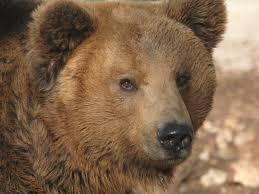
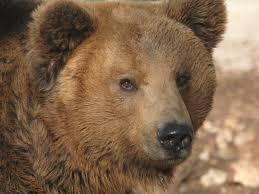
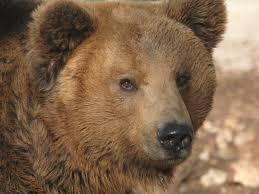

SUCCESS - saved https://upload.wikimedia.org/wikipedia/commons/4/4b/Ursidae-01.jpg - as ./scrapped_images/bear/6b7eb1495e.jpeg
SUCCESS - saved https://i.guim.co.uk/img/media/bcd9b1ca747ed4d274a70eb884f70ef91f5d313b/0_81_1440_864/master/1440.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=ae28448f331de098c72ad55d6b48beec - as ./scrapped_images/bear/2ee2615369.jpeg
SUCCESS - saved https://lh3.googleusercontent.com/proxy/FyAZ511GlmqPHj09mP6KXw0YtuoKhyeBxMRuY9LQN49yzilMr-O46pdVPndL3zRYJhW6Rap_hLVvVDeOtrxG53xr7VtHrBL4jp_UKjkMJJN-dzcloSfdPija2rXmpJkGpLmvmFG8yWVVe84EFlWSRMhyN97WWYC7yZHR - as ./scrapped_images/bear/52d8693366.jpeg
SUCCESS - saved https://images.theconversation.com/files/175247/original/file-20170622-26496-7ff7v5.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=900.0&fit=crop - as ./scrapped_images/bear/5ab5523a61.jpeg
SUCCESS - saved https://www.oysterworldwide.com/panel/wp-content/uploads/2014/02/Project_Romania_Bear_in_woods.jpg - as ./scrapped_images/bear/34665d6bf

SUCCESS - saved https://media2.ledevoir.com/images_galerie/nwd_538028_392880/image.jpg - as ./scrapped_images/panda/9ed2bf685f.jpeg
SUCCESS - saved https://cdn.futura-sciences.com/buildsv6/images/largeoriginal/7/1/6/71655ac356_50166765_panda-ge-ant-naissance.jpg - as ./scrapped_images/panda/133abb945a.jpeg
SUCCESS - saved https://actus.zoobeauval.com/wp-content/uploads/2019/07/AP9I0679.jpg - as ./scrapped_images/panda/2d3ceb4dde.jpeg
Found: 100 search results. Extracting links from 0:100
Found: 10 image links, done!
SUCCESS - saved https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=0.672xw:1.00xh;0.166xw,0&resize=640:* - as ./scrapped_images/dog/4fdbeb98ad.jpeg
SUCCESS - saved https://cdn.vox-cdn.com/thumbor/I2j0dg1lF7jg_Ff_eV96dvtEZ1k=/0x0:1200x675/1400x1050/filters:focal(504x242:696x434):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/67224712/pop_culter_dog_rank_alyceatinoyan_feature.0.jpg - as ./scr

In [111]:
from PIL import Image
from io import BytesIO
import hashlib

animals = ['Chicken bird', 'Bear', 'Elephant', 'Lion',
           'Eagle', 'Panda', 'Dog']
#search_and_download('Chicken', DRIVER_PATH, target_path='./images', number_images=10)

for animal in animals:
    search_and_download(animal, DRIVER_PATH, target_path='./scrapped_images', number_images=10)

## 17. Développer une interface utilisateur (Dash) permettant de charger une image, puis de retourner le label de l’image (la classe).

## 18. Quelles seraient les adaptations à faire pour offrir un logiciel de labellisation automatique ? Proposer un cahier des charges précis. Proposer une implémentation (une mise en œuvre). Réfléchir à la manière la plus appropriée de stocker les libellés des images afin que ceux-ci soient indépendant de l’application sur 

## 19. Après avoir réalisé une veille sur les tests unitaires, fonctionnels, de non-régression. Programmer vos tests unitaires et fonctionnels.

## 20. Afin de trouver facilement les images qui lui permettront d’appuyer ces présentations pédagogiques aux enfants de sa classe, votre ami souhaite une application similaire à Google Image dédiée à ses images contenues sur son disque dur. Que pouvez-vous lui proposer ? Quelles sont les types d’algorithmes qui permettent de réaliser ce type d’application ? 

## 21. Réfléchir à une solution de stockage des images.

## 22. Programmer votre propre application Google Image !!!! 